In [39]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy.stats import linregress
import os
from netCDF4 import Dataset

#For plotting binned velocity profile
from scipy.stats import binned_statistic as bstats

In [40]:
# Import and apply style file for plots
plt.style.use("mpl.style")

## System properties

In [41]:
#In LJ units

#System dimensions
d = 3

#Smoothing length coefficient
h3 = 3.5

#System size
L_x = 10 #Size of the system
L_y = L_x

#Fluid properties
eta = 0.01
rho = 1
nu = eta/rho

#Oscillation properties
u_0 = 0.1
k_x = 2*np.pi/L_x
k_y = 2*np.pi/L_y

#Decay timescale
tau = 1/nu/(k_x**2+k_y**2)

## Functions

In [42]:
#Calculate velocity from analytical solution to Taylor-Green Vortex
def vel_x_y_t(x,y,t,k_x,k_y,tau):
    u_x = u_0*np.cos(k_x*x)*np.sin(k_y*y)
    u_y = u_0*np.sin(k_x*x)*np.cos(k_y*y)
    u_t = np.exp(-t/tau)
    return np.sum(np.abs(u_x), axis=1)*u_t , np.sum(np.abs(u_y), axis=1)*u_t

In [43]:
#Compile all filenames (value) and properties (key) into a dictionary
def generate_file_names(filepath):
    data_files = {}

    for file in os.listdir(filepath):

        #Remove the .nc extension
        #Collect the info for the run in an array
        file_info = file.split(".")
        file_info = file_info[0].split("_")

        #File name
        file_name = file

        #Add the files to datafiles dictionary
        data_files[(file_info[0],file_info[1],file_info[2])]= filepath + "/" + file_name
    return data_files

In [44]:
#Calculate values needed to plot kinetic energy decay
def calc_kinetic_energy_decay(ds, mp, N):
    
    #Kinetic energy from data
    td = ds["time"][:]
    xd = ds['coordinates'][:,:,0] #At timestep nf, for all particles, x position
    yd = ds["coordinates"][:,:,1] #At timestep nf, for all particles, y position
    vxd = ds["velocities"][:,:,0] #At timestep nf, for all particles, x position
    vyd = ds['velocities'][:,:,1] #At timestep nf, for all particles, y velocity
    Exd = 0.5*mp*(np.sum(np.abs(vxd), axis=1))**2
    Eyd = 0.5*mp*(np.sum(np.abs(vyd), axis=1))**2
    E_tot = Exd+Eyd

    #Kinetic energy from analytic solution
    ref_vx, ref_vy = vel_x_y_t(xd,yd,td,k_x,k_y,tau)
    ref_Ex = 0.5*mp*(ref_vx)**2
    ref_Ey = 0.5*mp*(ref_vy)**2
    ref_E_tot = (ref_Ex + ref_Ey)

    return td, E_tot, ref_E_tot

#Calculate values needed to plot viscosity error
def calc_viscosity_error(td, E_tot, ref_E_tot):

    #all_run_info = kinetic_energy_decay[1]
    
    #Viscosity calculation from slope of semilogy(E_tot vs t)
    slope_d = linregress(td, np.log(E_tot))[0]
    nu_d = -slope_d/(2*(k_x**2+k_y**2)) #Kinematic viscosity from data
        
    #Viscosity calculation from analytical solution
    slope_ref = linregress(td, np.log(ref_E_tot))[0]
    nu_ref = -slope_ref/(2*(k_x**2+k_y**2)) #Kinematic viscosity from data

    #Error
    nu_error = np.abs(nu_ref-nu_d)
    
    return nu_error


In [45]:
#Benchmark by plotting kinetic energy decay and viscosity
def benchmark(data_files):
    
    fig, ax = plt.subplots(2,1,figsize=(15,15))
    all_run_info = []

    for run in data_files:
        run_info = list(run)[0:2]
        ds = Dataset(data_files[run])

        #Scaling variables
        sf = 1/int(list(run)[2]) #Scaling of unit cell
        L_z = h3*(d-2)*sf #Account for L_z if d=3
        n = 1/sf**d #Number density - number of particles per volume
        mp = rho/n #Mass of particles (density is constant)

        if d == 3:
            N = L_x*L_y*L_z/sf**d # Total number of atoms
        elif d == 2:
            N = L_x*L_y/sf**d 

        run_info.append(sf)
        
        #Calculate kinetic energy decay and plot it
        td, E_tot, ref_E_tot = calc_kinetic_energy_decay(ds, mp, N)
        ax[0].semilogy(td, E_tot/E_tot[0], label = run_info[0:3])
        
        #Calculate viscosity error
        run_info.append(calc_viscosity_error(td, E_tot, ref_E_tot))
        
        all_run_info.append(run_info)
    
    #Plot KE decay from analytical velocity profile
    ax[0].semilogy(td, ref_E_tot/ref_E_tot[0], "--", label = "Analytical Solution")
    
    #Format kinetic energy decay plot
    ax[0].legend(bbox_to_anchor=(1,1), loc="upper left")
    ax[0].set_ylabel(r"$\log{(\frac{KE}{KE_0})}$")
    ax[0].set_xlabel("t")
    
    #Plot viscosity error
    df = pd.DataFrame(all_run_info, columns=["Shifting","RK","sf","Viscosity Error"])
    df.sort_values(by=["sf"], inplace=True)
    
    for i in df["Shifting"].unique():
        df_1 = df[df["Shifting"]==i]
        for j in df_1["RK"].unique():
            df_2 = df_1[df_1["RK"]==j]
            label = "Shifting: " + i + "  " +"RK: " + j
            ax[1].loglog(df_2["sf"],df_2["Viscosity Error"],label=label)
            #nu_error_slope = df_2["sf"].corr(df_2["Viscosity Error"])
            #print("Slope: " + str(nu_error_slope))
            #print(np.diff(np.log(df_2["Viscosity Error"]))/np.diff(np.log(df_2["sf"])))
            print(df_2)

    #Format viscosity error plot
    ax[1].legend()
    ax[1].set_ylabel('Viscosity Error')
    ax[1].set_xlabel(r"${\Delta x}$")
    
    plt.tight_layout()

  Shifting RK    sf  Viscosity Error
0        1  1  0.10         0.000264
3        1  1  0.20         0.002186
4        1  1  0.25         0.004280
6        1  1  0.50         0.011956
  Shifting RK    sf  Viscosity Error
1        0  0  0.20         0.025957
2        0  0  0.25         0.019017
5        0  0  0.50         0.019134


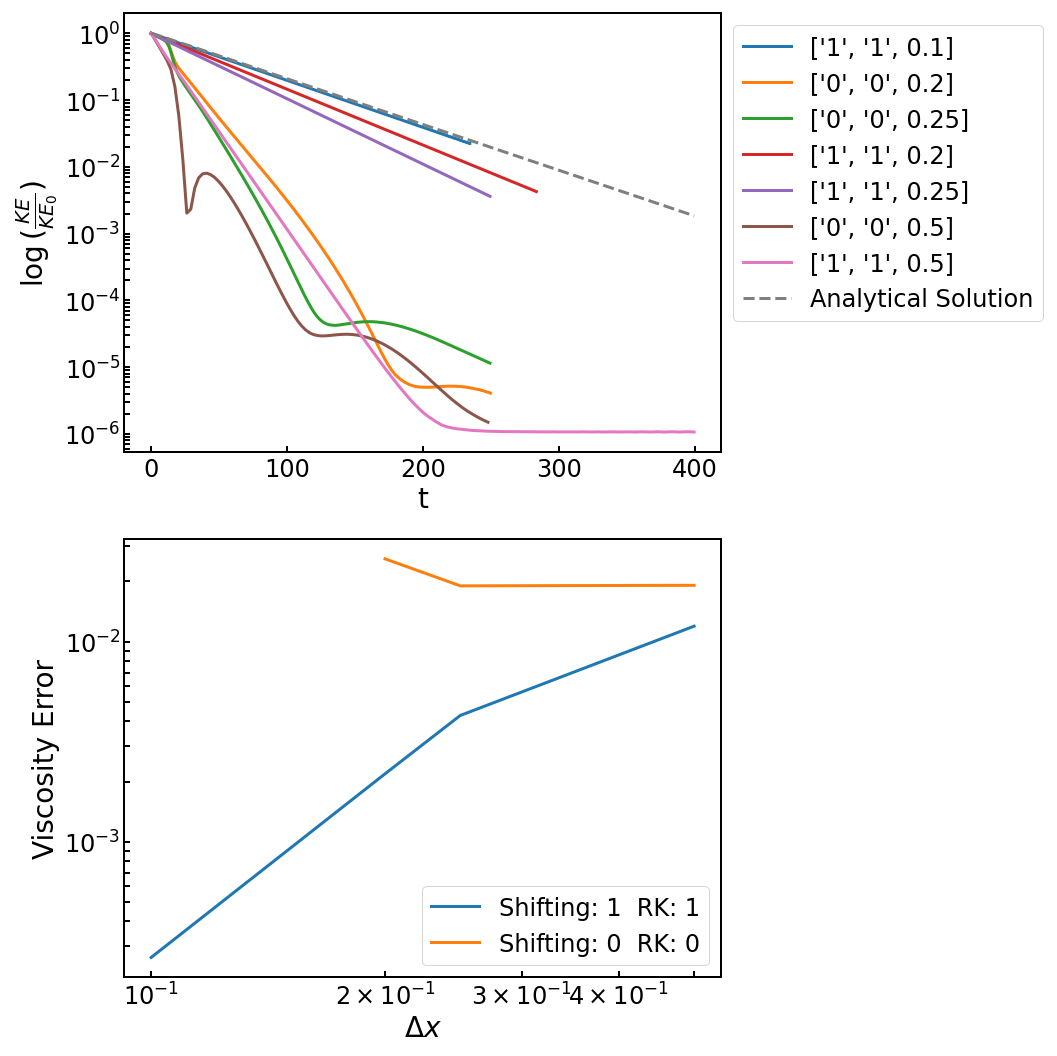

In [49]:
filepath = '/home/epalermo/dev/test/taylor_green_3D/data_files/variable_timestep'
benchmark(generate_file_names(filepath))